# Some Calculations

## ProDOT system

Original paper: [Ioan2021](https://pubs.acs.org/doi/abs/10.1021/acs.macromol.0c02132)

In [1]:
from ase.io import read, write
from quippy import descriptors
import numpy as np
import random
import time
import os, sys
from tqdm import tqdm

In [2]:
sys.path.append('../../')

In [3]:
from src import myTools, plotTools

## System loading

In [4]:
sysdir_path = '../0.data/'
sysname = 'ProDOT-2Hex-00PC-cryst.xyz'

### Read trajectory

In [5]:
slicer = slice(None,1,None)

In [6]:
traj = read(sysdir_path+sysname, 
            index=slicer, format='xyz')

In [7]:
print(f"Tot frames: {len(traj)}")

Tot frames: 1


Atomic Species:

In [8]:
print(f"Z = {np.unique(traj[0].numbers)} - tot({len(np.unique(traj[0].numbers))})")
print(f"N_z = {[np.bincount(traj[0].numbers)[nz] for nz in np.unique(traj[0].numbers)]}")

Z = [ 1  3  6  8 16] - tot(5)
N_z = [2416, 1, 1520, 160, 80]


## Analysis

### Descriptor computation

In [9]:
def ps_fbyf(sys_name, ds_obj, f_range=1):
    
    ps_list = list()
    
    for f in tqdm(range(f_range)):
        snap_tmp = read(sys_name, index=f, format='xyz')
        ps_tmp = ds_obj.calc_descriptor(snap_tmp)
        ps_list.append(ps_tmp)

    return np.concatenate(ps_list)

### Li atom

In [10]:
ds_str = 'soap cutoff=6.0 \
          cutoff_transition_width=1.0 \
          n_max=8 l_max=4 atom_sigma=0.5 \
          n_Z=1 Z={3} \
          n_species=5 species_Z={1 3 6 8 16}'

In [11]:
ds = descriptors.Descriptor(ds_str)

In [12]:
ds.n_dim

4101

In [13]:
ps_mf = ps_fbyf(sysdir_path+sysname,
                ds_obj=ds, f_range=1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [28:28<00:00,  1.71s/it]


In [14]:
ps_mf.shape

(1000, 4101)

In [15]:
np.save('ps_Li_1000_ev1', ps_mf)

## Representations

In [31]:
from sklearn.decomposition import PCA, KernelPCA

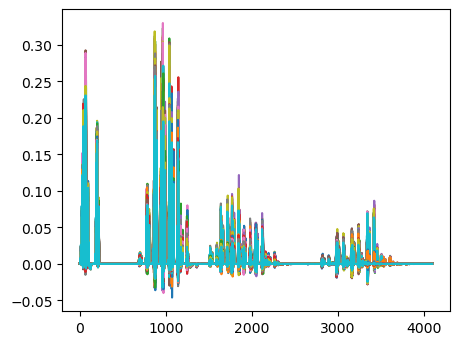

In [34]:
fig, ax = plotTools.get_axes(1,1, res=100)
for spectra in ps_mf:
    ax.plot(spectra)

### Linear PCA

In [35]:
N = 5
pca_model = PCA(n_components=N)

In [41]:
lpca = pca_model.fit_transform(ps_mf)
print(f"Shape:{lpca.shape}, \
      var={np.around(pca_model.explained_variance_ratio_, 2)}")

Shape:(100, 5),       var=[0.6  0.13 0.06 0.03 0.02]


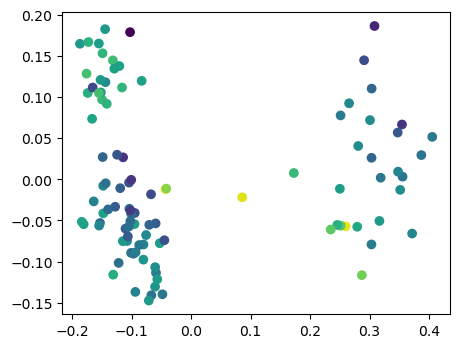

In [59]:
fig, ax = plotTools.get_axes(1,1,res=100)
ax.scatter(lpca[:,0], lpca[:,1], c=lpca[:,2])

### kernel PCA

In [55]:
kpca_model = KernelPCA(n_components=5, 
                       kernel='cosine')

In [56]:
kpca = kpca_model.fit_transform(ps_mf)
print(f"Shape:{kpca.shape}")

Shape:(100, 5)


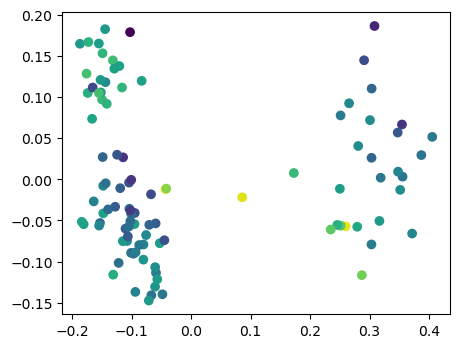

In [58]:
fig, ax = plotTools.get_axes(1,1,res=100)
ax.scatter(kpca[:,0], kpca[:,1], c=kpca[:,2])

### MDS

In [66]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, Isomap

In [61]:
cos_sim_matrix = cosine_similarity(ps_mf)
cos_sim_matrix.shape

(100, 100)

In [63]:
embedding = MDS(n_components=3, dissimilarity='precomputed')

In [64]:
mds = embedding.fit_transform(cos_sim_matrix)
mds.shape

(100, 3)

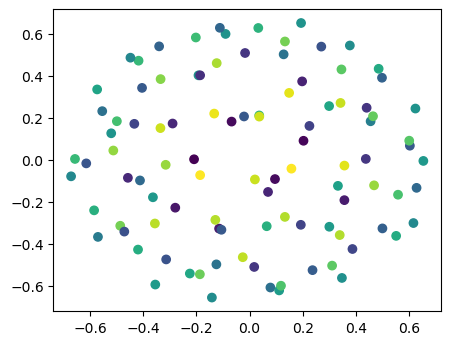

In [65]:
fig, ax = plotTools.get_axes(1,1,res=100)
ax.scatter(mds[:,0], mds[:,1], c=mds[:,2])

### Isomap

In [67]:
from scipy.spatial.distance import cosine

In [68]:
embedding = Isomap(n_components=3, metric='cosine')

In [69]:
isomap = embedding.fit_transform(cos_sim_matrix)
isomap.shape

(100, 3)

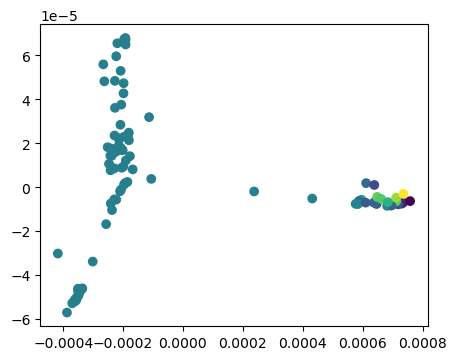

In [70]:
fig, ax = plotTools.get_axes(1,1,res=100)
ax.scatter(isomap[:,0], isomap[:,1], c=isomap[:,2])